## Семинар 9: "LSTM"

ФИО: Валиахметов Булат Ильдарович

In [907]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset

from train_utils import train

%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [632]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        # self.linear = nn.Linear(hidden_size, output_size)
        
        # self.state_hid = (torch.zeros(1, 1, hidden_size), torch.ones(1, 1, hidden_size))
        
        
    def forward(self, inputs, hidden):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = torch.autograd.Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

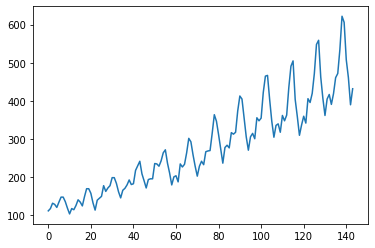

In [908]:
%matplotlib inline
dataset = pd.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [634]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [635]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [860]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_forward + 1):
        cut = dataset[i : (i + look_back + look_forward), 0]
        dataX.append(cut[:look_back])
        dataY.append(cut[look_back:])

    return np.array(dataX), np.array(dataY)

In [891]:
# Пример подготовленных данных

look_back = 14
look_forward = 3
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [892]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader =  DataLoader(train_dataset, batch_size=5)

In [893]:
test_dataset = TensorDataset(torch.from_numpy(testX), torch.from_numpy(testY))
test_dataloader =  DataLoader(test_dataset, batch_size=5)

In [894]:
my_net = LSTM(look_back, look_forward)
pt_net = nn.LSTM(input_size=look_back, hidden_size=look_forward, num_layers=1)
pt_gru = nn.GRU(input_size=look_back, hidden_size=look_forward, num_layers=1)

In [895]:
def MAPEloss(y_true, y_pred):
    err = torch.mean(torch.abs(y_true - y_pred) + 1e-6 / (torch.abs(y_true) + 1e-6))
    return err


def train_model(model, epochs=100, train_dataloader=train_dataloader, 
                hidden_size=look_forward, gru=False):
    criterion = MAPEloss
    # criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(epochs):
        if not gru:
            hidden = (torch.zeros(1, 1, hidden_size),
                      torch.zeros(1, 1, hidden_size))
        else:
            hidden = torch.zeros(1, 1, hidden_size)        
        for x, y in train_dataloader:
            optimizer.zero_grad()
            Y_pred, hidden = model(x, hidden)
            loss = criterion(y, Y_pred.view(*y.size()))
            loss.backward()
            optimizer.step()
            if not gru:
                hidden[0].detach_()
                hidden[1].detach_()
            else:
                hidden.detach_()
        if (epoch + 1) % 50 == 0 or epoch + 1 == epochs:
            print(f'\repoch {epoch + 1}: loss {loss.item()}', end='')
        
        
def eval_model(model, test_dataloader=test_dataloader, hidden_size=look_forward, gru=False):
    criterion = MAPEloss
    # criterion = torch.nn.L1Loss()
    if not gru:
        hidden = (torch.zeros(1, 1, hidden_size),
                  torch.zeros(1, 1, hidden_size))
    else:
        hidden = torch.zeros(1, 1, hidden_size)
    model.zero_grad()
    loss = 0
    counts = 0
    result = []
    for x, y in test_dataloader:
        predY, hidden = model(x, hidden)
        loss_batch = criterion(y, predY.view(*y.size()))
        loss += loss_batch.item()
        result += list(predY[:, 0, 0].detach().numpy().flatten())
        counts += predY.shape[0]
    print(f'result : {loss/counts}')
    return result

In [896]:
train_model(my_net, 1000)

epoch 1000: loss 0.006263921968638897

In [897]:
my_res = eval_model(my_net)

result : 0.011415381100960076


In [898]:
train_model(pt_net, 1000)

epoch 1000: loss 0.0067285941913723946

In [899]:
pt_res = eval_model(pt_net)

result : 0.01095460494980216


In [900]:
train_model(pt_gru, 1000, gru=True)

epoch 1000: loss 0.013424839824438095

In [901]:
gru_res = eval_model(pt_gru, gru=True)

result : 0.011817279446404427


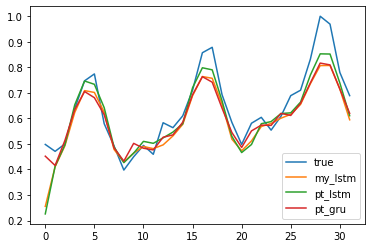

In [902]:
plt.plot(testY[:, 0])
plt.plot(my_res)
plt.plot(pt_res)
plt.plot(gru_res)
plt.legend(['true', 'my_lstm', 'pt_lstm', 'pt_gru'])

In [903]:
def predict_time(model, prev_data, eval_cnt, look_back=look_back, look_forward=look_forward, gru=False):
    if not gru:
        hidden = (torch.zeros(1, 1, look_forward),
                  torch.zeros(1, 1, look_forward))
    else:
        hidden = torch.zeros(1, 1, look_forward)
    model.zero_grad()
    loss = 0
    counts = 0
    result = torch.zeros(size=(len(prev_data) + eval_cnt + look_forward - 1, ), requires_grad=False)
    result[:len(prev_data)] = torch.FloatTensor(prev_data).view(-1, )
    for i in range(len(prev_data), len(prev_data) + eval_cnt):
        x = result[i - look_back : i].view(1, 1, -1)
        result[i : i + look_forward], hidden = model(x, hidden)
    return result[:len(prev_data) + eval_cnt].detach().numpy().flatten()

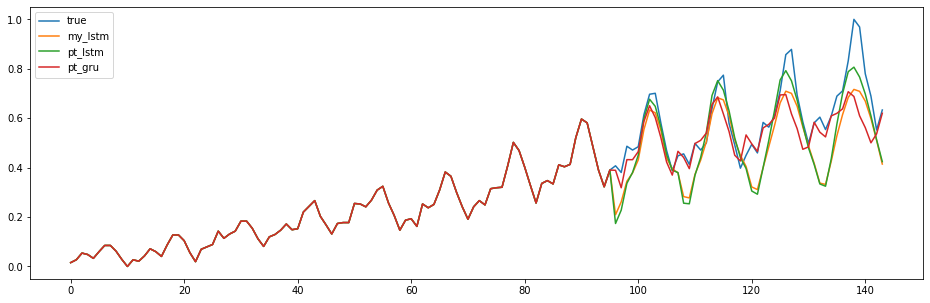

In [904]:
plt.figure(figsize=(16, 5))
plt.plot(dataset)
plt.plot(predict_time(my_net, train, len(test)))
plt.plot(predict_time(pt_net, train, len(test)))
plt.plot(predict_time(pt_gru, train, len(test), gru=True))
plt.legend(['true', 'my_lstm', 'pt_lstm', 'pt_gru'])

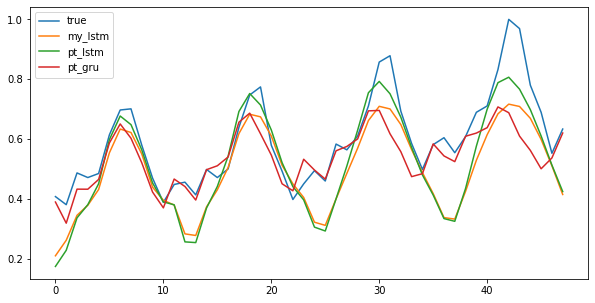

In [905]:
plt.figure(figsize=(10, 5))
plt.plot(dataset[96:])
plt.plot(predict_time(my_net, train, len(test))[96:])
plt.plot(predict_time(pt_net, train, len(test))[96:])
plt.plot(predict_time(pt_gru, train, len(test), gru=True)[96:])
plt.legend(['true', 'my_lstm', 'pt_lstm', 'pt_gru'])

**Выводы**:
* Чем дальше от train'а, тем менне точное предсказание (ожидаемо).
* GRU точнее улавливает локальные скачки, LSTM сильно заносит на глобальных пиках.
* На бОльших look_back и look_forward все модели начинают сильно сглаживать решение.
* Все модели не могут "держать тренд" - на больших номерах итераций рост пиков замедляется.

## Задание 3 

Поучаствуйте в соревновании https://www.kaggle.com/t/374fc477c4744b009a837153ce135cfb 

Для зачета задания нужно получить значение MAPE меньше 0.2

До 1 мая 2021 можно получить 3,2,1 дополнительных балла за 1, 2 и 3 место соответственно.


Опиционально: сравните классические подходы (ARIMA, gradient boosting trees и RNN)

In [1125]:
df  = pd.read_csv('train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    1096 non-null   object
 1   hits    1096 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.2+ KB


In [1126]:
data = df.hits.values
data

array([201979088, 223095158, 233791442, ..., 195884690, 125587958,
       110355560])

In [1142]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(data.reshape(-1, 1)).astype('float32')
train_data.shape

(1096, 1)

In [1143]:
trainX, trainY = create_dataset(train_data, look_back=look_back, look_forward=look_forward)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataloader =  DataLoader(train_dataset, batch_size=32)

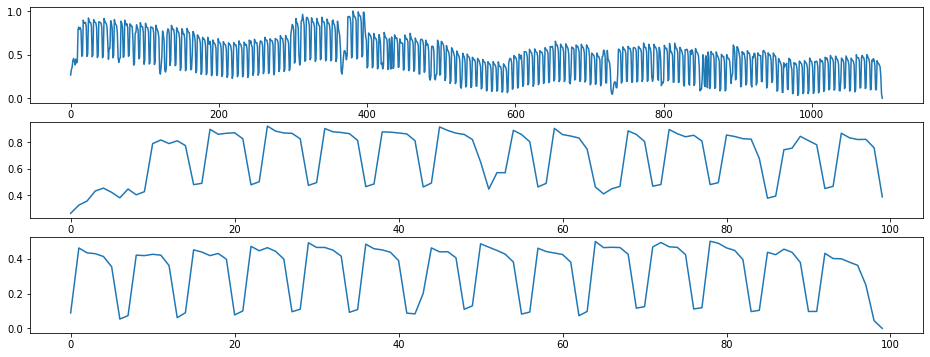

In [1129]:
plt.figure(figsize=(16, 6))
plt.subplot(311)
plt.plot(train)
plt.subplot(312)
plt.plot(train[:100])
plt.subplot(313)
plt.plot(train[-100:])

In [1130]:
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lstm_layers, gru_layers):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=lstm_layers)
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=gru_layers)
        self.lstm_hidden = (torch.zeros((lstm_layers, 1, hidden_size), requires_grad=False),
                            torch.zeros((lstm_layers, 1, hidden_size), requires_grad=False))
        self.gru_hidden = torch.zeros((gru_layers, 1, hidden_size), requires_grad=False)
        self.linear = nn.Sequential(nn.Linear(2 * hidden_size, 4 * hidden_size),
                                    nn.ReLU(), 
                                    nn.Linear(4 * hidden_size, output_size))
        
        
    def reset_state(self):
        self.lstm_hidden = (torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))
        self.gru_hidden = torch.zeros(1, 1, hidden_size)
        
        
    def forward(self, x):
        lstm_pred, self.lstm_hidden = self.lstm(x, self.lstm_hidden)
        gru_pred, self.gru_hidden = self.gru(x, self.gru_hidden)
        # print(torch.cat([lstm_pred, gru_pred], dim=2).shape)
        return self.linear(torch.cat([lstm_pred, gru_pred], dim=-1))

In [1131]:
look_back = 20
look_forward = 1
hidden_size = 100
lstm_layers = 1
gru_layers = 1

params = {
    'input_size': look_back,
    'output_size': look_forward,
    'hidden_size': hidden_size,
    'lstm_layers': lstm_layers,
    'gru_layers': gru_layers
}

In [1132]:
net = MyModel(**params)

In [1133]:
net.lstm_hidden[0].dtype

torch.float32

In [1134]:
def train(model, epochs=100, lr=0.001, train_dataloader=train_dataloader, model_params=params):
    criterion = MAPEloss
    # criterion = torch.nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.reset_state();
        for x, y in train_dataloader:
            model.zero_grad()
            Y_pred = model(x)
            loss = criterion(y, Y_pred.view(*y.size()))
            loss.backward()
            optimizer.step()
            model.lstm_hidden[0].detach_()
            model.lstm_hidden[1].detach_()
            model.gru_hidden.detach_()
        if (epoch + 1) % 25 == 0 or epoch + 1 == epochs:
            print(f'\repoch {epoch + 1}: loss {loss.item()}', end='')

In [1135]:
train(net, 300)

epoch 300: loss 0.08045623451471329

In [1144]:
def predict_next(model, prev_data, eval_cnt, look_back=look_back, look_forward=look_forward):
    with torch.no_grad():
        result = torch.zeros(size=(len(prev_data) + eval_cnt + look_forward - 1, ), requires_grad=False)
        result[:len(prev_data)] = torch.FloatTensor(prev_data).view(-1, )
        model.reset_state()
        for i in range(len(prev_data), len(prev_data) + eval_cnt):
            x = result[i - look_back : i].view(1, 1, -1)
            result[i : i + look_forward] = model(x)
    return result[:len(prev_data) + eval_cnt].detach().numpy().flatten()

In [1146]:
pred = predict_next(net, train_data, 365)

In [1157]:
pred_last = scaler.inverse_transform(pred[-365:].reshape(-1, 1))

In [1158]:
pred_df = pd.read_csv('sample_submission.csv')

In [1174]:
pred_df.hits = pred_last.astype('int64')

In [1177]:
pred_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    365 non-null    object
 1   hits    365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [1184]:
pred_df.to_csv('submit1.csv', index=False, columns=['date', 'hits'])

In [1167]:
pred_df_2 = pd.read_csv('sample_submission.csv')

In [1185]:
pred_df_3 = pd.read_csv('submit1.csv')

In [1186]:
pred_df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    365 non-null    object
 1   hits    365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [1187]:
pred_df_3

,date,hits
0,2019-01-01,110939544
1,2019-01-02,188836960
2,2019-01-03,243641968
3,2019-01-04,231967088
4,2019-01-05,141527168
...,...,...
360,2019-12-27,434481216
361,2019-12-28,434350048
362,2019-12-29,434309792
363,2019-12-30,434359136


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: